# Setup

Import basic packages and bring in lookup tables for clinical conditions and medications and pre-defined mapping functions.

#### Packages

In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import combinations
# set number of rows pandas dataframe displays
pd.set_option('display.max_rows', 3000)

#### Lookup tables

In [2]:
lkp_med = pd.read_csv('S:\CALIBER_17_205R\MSc\Oliver\Lookup Tables\lookup_medical_table.csv', sep=',')
lkp_med_code_dic = pickle.load(open('S:\CALIBER_17_205R\MSc\Oliver\Python Code\lkp_med_code_dic.p', 'rb'))
lkp_med_term_dic = pickle.load(open('S:\CALIBER_17_205R\MSc\Oliver\Python Code\lkp_med_term_dic.p', 'rb'))

lkp_bnf = pd.read_csv('S:\CALIBER_17_205R\MSc\Oliver\Lookup Tables\lookup_bnf_table.csv', 
                      sep=',', dtype={'bnfcode':str, 'bnf':str})

lkp_prd = pd.read_csv('S:\CALIBER_17_205R\MSc\Oliver\Lookup Tables\lookup_product_table.csv', sep=',', 
                      low_memory=False)

#### Mappings from helper_functions

In [3]:
from helper_functions import medcode_to_read, medcode_to_term, read_to_medcode, cprd_to_bnf, bnf_to_chapter
from helper_functions import get_stat_dic

#### Disease readcode lists

Predominantly taken from ClinicalCodes.org

In [4]:
# diabetes
db_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\diabetes.csv', sep=',')
diabetes_readcodes = list(db_csv['code'])

# heart-failure
hf_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\heart-failure.csv', sep=',')
heartfailure_readcodes = list(hf_csv['code'])

# thrombosis
tm_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\res25-p16_thrombosis.csv', sep=',')
thrombosis_readcodes = list(tm_csv['code'])

# mild-liver-disease
ld_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\res27-mild-liver-disease.csv', sep=',')
liverdisease_readcodes = list(ld_csv['code'])

# renal-disease
rd_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\res27-renal-disease.csv', sep=',')
renaldisease_readcodes = list(rd_csv['code'])

# hypertension
ht_csv = pd.read_csv(r'S:\CALIBER_17_205R\MSc\Oliver\Clinical Code Lists\hypertension.csv', sep=',')
hypertension_readcodes = list(ht_csv['code'])

Construct disease_dic from the readcodes specified above, to feed into the build_data function

In [5]:
disease_dic = {'db':diabetes_readcodes,
               'hf':heartfailure_readcodes,
               'tm':thrombosis_readcodes,
               'ld':liverdisease_readcodes,
               'rd':renaldisease_readcodes,
               'ht':hypertension_readcodes}

# Testing Generalizability

#### Packages

Packages imported from SKLearn, XGBoost and user-defined functions

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from helper_functions import add_neg_patids, build_data

Cross-validation will be done over 5 folds

In [7]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)

## 1. Test 135 model on other hypertensives + drugs

#### Load estimator from 135 analysis

In [8]:
# best estimator from grid search on 135 data
# estimator = pickle.load(open(r'S:\CALIBER_17_205R\MSc\Oliver\Python Code\135_analysis\model_all_data_135.p', 'rb'))
# estimator = pickle.load(open(r'S:\CALIBER_17_205R\MSc\Oliver\Python Code\model_best.p', 'rb'))
# estimator = pickle.load(open(r'S:\CALIBER_17_205R\MSc\Oliver\Python Code\model_best_on_84.p', 'rb'))
estimator_135 = pickle.load(open(r'S:\CALIBER_17_205R\MSc\Oliver\Python Code\135_analysis\model_eha_unbalanced_135.p', 'rb'))

# target, version and eventdate of selected classifier
target = 'patids_v1a_pos'
version = 'v1'
eventdate = 'eventdate_min'
filter_type = '12_mnth'

# features used in selected classifier
feature_dic = {'patient_profile':True,
               'drug_metrics_profile':True,
               'bnf_profile':True,
               'bnf_pca_profile':{'include':False,
                                  'pca':None},
               'disease_profile':True}

#### Loop through hypertension + drugs and evaluate

In [26]:
drug_list = [5, 17, 135, 142, 150, 84]

results = []
results_formatted = []

for drug in drug_list:

    # initialize test AUC score lists
    te_au = []
    
    # load and unpack stat_dic for each drug
    stat_dic, target_list, patids_neg_dic, filter_6_mnth, filter_12_mnth = get_stat_dic(drug)
    
    # get a list of positive and negative patients as per the target, version and eventdate
    patids_pos = [patid for patid in list(stat_dic.keys()) 
                    if stat_dic[patid]['target'][target][0]==1]
    patids_pos = list(set.intersection(set(patids_pos), 
                                       set(filter_12_mnth) if filter_type=='12_mnth' else set(filter_6_mnth)))
    patids_neg = list(set(patids_neg_dic[version]) - \
                                       set(filter_12_mnth) if filter_type=='12_mnth' else set(filter_6_mnth))

    patids = patids_pos + patids_neg
    random.seed(0)
    random.shuffle(patids)
    
    # build X and y data for these patients
    X, y, dic = build_data(stat_dic, patids, feature_dic, disease_dic, 
                           lkp_bnf, lkp_prd, eventdate, target, tdqm_display=False)
    
    k_fold_index_set = list(kf.split(X))
    
    for fold in range(k_folds):
        # split the data in to the k-th fold using SKLearn k-fold split
        _, test_idx = k_fold_index_set[fold]
        _, _, X_test, y_test = _, _, X[test_idx], y[test_idx]
    
        # get data in required format for XGBoost
        ddata = xgb.DMatrix(X_test, label=y_test, feature_names=list(dic.values()))
        
        # calculate required metrics for train and test then append to score lists
        te_au.append(roc_auc_score(y_test, [round(pred) for pred in estimator_135.predict(ddata, output_margin=True)]))
        ### requires output_margin=True when testing on AUC, otherwise False for e.g. accuracy ###

    # calculate mean and standard deviation over the k-fold cross validation and append to results lists
    result = [drug,
              round(np.mean(np.array(te_au)),3),
              round(np.std(np.array(te_au)),3)]       
    results.append(result)

    result_formatted = [drug,
                        f'{round(np.mean(np.array(te_au)),2)}+/-{round(np.std(np.array(te_au)),2)}']
    results_formatted.append(result_formatted)

    # print result to screen
    print(result_formatted)

[5, '0.82+/-0.01']
[17, '0.81+/-0.01']
[135, '0.85+/-0.01']
[142, '0.79+/-0.02']
[150, '0.68+/-0.01']
[84, '0.67+/-0.05']


In [ ]:
# mean ages across drugs

# 5: 63.614248145635315
# 17: 65.92641654798555
# 135: 65.68368214703445
# 142: 66.91171431412003
# 150: 76.12419712385608
# 84: 48.34163192376414

## 2. Build a combined classifier

#### Combine the hypertension medication data

In [8]:
# target, version and eventdate of selected classifier
target = 'patids_v1a_pos'
version = 'v1'
eventdate = 'eventdate_min'
filter_type = '12_mnth'

# features used in selected classifier
feature_dic = {'patient_profile':True,
               'drug_metrics_profile':True,
               'bnf_profile':True,
               'bnf_pca_profile':{'include':False,
                                  'pca':None},
               'disease_profile':True}

X_comb = np.zeros((1, 2377)) # 2377 features with patient / drug_metric / bnf / disease profiles
y_comb = np.zeros((1, 1))

# list of drugs to aggregate data over - selected hypertensive drugs in this case
drug_list = [5, 17, 135, 142]

for drug in drug_list:
    
    # load and unpack stat_dic for each drug
    stat_dic, target_list, patids_neg_dic, filter_6_mnth, filter_12_mnth = get_stat_dic(drug)
    
    # get a list of positive and negative patients as per the target, version and eventdate
    patids_pos = [patid for patid in list(stat_dic.keys()) 
                    if stat_dic[patid]['target'][target][0]==1]
    patids_pos = list(set.intersection(set(patids_pos), 
                                       set(filter_12_mnth) if filter_type=='12_mnth' else set(filter_6_mnth)))
    patids_neg = list(set(patids_neg_dic[version]) - \
                                       set(filter_12_mnth) if filter_type=='12_mnth' else set(filter_6_mnth))

    patids = patids_pos + patids_neg
    random.seed(0)
    random.shuffle(patids)
    
    # build X and y data for these patients
    X, y, dic = build_data(stat_dic, patids, feature_dic, disease_dic, 
                           lkp_bnf, lkp_prd, eventdate, target, tdqm_display=False)
    
    X_comb = np.concatenate((X_comb, X), axis=0)
    y_comb = np.concatenate((y_comb, y), axis=0)
    
X_comb = np.delete(X_comb, 0, axis=0)
y_comb = np.delete(y_comb, 0, axis=0)

# size of data
n = len(X_comb)

# shuffle data
np.random.seed(0)
shuffler = np.random.permutation(n)
X_comb = X_comb[shuffler]
y_comb = y_comb[shuffler]

In [9]:
# get weights for the unbalanced data
w_0 = len(y_comb) / (2 * sum(y_comb==0))
w_1 = len(y_comb) / (2 * sum(y_comb==1))

#### Grid-search for best parameters

In [11]:
# use test set for early stopping in GridSearch
X_train, X_test, y_train, y_test = train_test_split(X_comb, y_comb, test_size=1/6, random_state=0)

# use last dic from for loop to map columns to feature names (all dics should be the same)
X_train_df = pd.DataFrame(data=X_train, columns=list(dic.values()))
X_test_df = pd.DataFrame(data=X_test, columns=list(dic.values()))

In [10]:
grid_params = {'objective':['binary:logistic'], 'eval_metric':['auc'], 
               # if not gridsearch, set large enough that never reached because applying early stopping criteria
               'n_estimators':[200], 
               'max_depth':[3,4,5,6], 'eta':[0.1,0.15,0.2,0.25,0.3], 'min_child_weight':[2,4,8,16,32,64]}

# using SKLearn API for grid search and better printing of trees
model = xgb.XGBClassifier(use_label_encoder=False)
gridsearch = GridSearchCV(model, grid_params, scoring='roc_auc', refit=True, cv=5)
gridsearch.fit(X_train_df, y_train.flatten(), sample_weight=[w_0 if y_train_i==0 else w_1 for y_train_i in y_train],
               early_stopping_rounds=10, eval_set=[(X_test_df, y_test.flatten())],
               verbose=False)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, us

In [11]:
# best parameters
gridsearch.best_params_

# {'eta': 0.1,
#  'eval_metric': 'auc',
#  'max_depth': 4,
#  'min_child_weight': 64,
#  'n_estimators': 200,
#  'objective': 'binary:logistic'}

{'eta': 0.1,
 'eval_metric': 'auc',
 'max_depth': 4,
 'min_child_weight': 64,
 'n_estimators': 200,
 'objective': 'binary:logistic'}

In [10]:
params = {'max_depth':4, 'eta':0.1, 'objective':'binary:logistic', 'eval_metric':'auc', 'min_child_weight':64}

In [18]:
# best parameters
gridsearch.best_score_

0.8283002506067934

In [12]:
# save best booster
pickle.dump(gridsearch.best_estimator_.get_booster(), open('booster_best_24082021.p', 'wb'))

In [13]:
# save best estimator
pickle.dump(gridsearch.best_estimator_, open('estimator_best_24082021.p', 'wb'))

In [35]:
estimator = pickle.load(open('estimator_best_24082021.p', 'rb'))

In [20]:
# save best estimator
pickle.dump(gridsearch, open('gridsearch_24082021.p', 'wb'))

#### Vizualizations

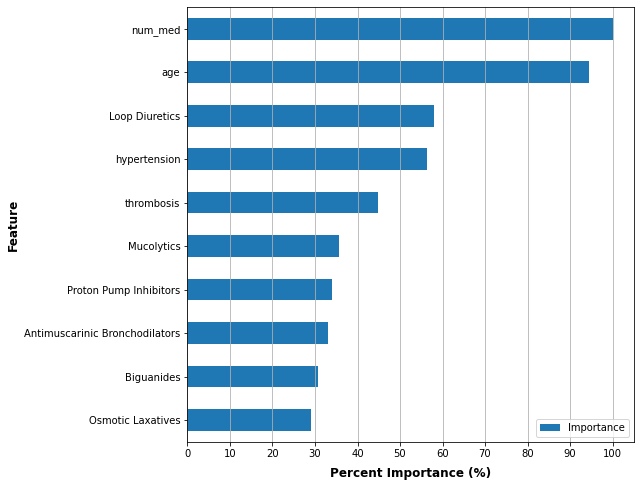

In [37]:
topk = 10

# sort model importances and take top k
sorted_importance = {k:v for k,v in sorted(estimator.get_booster().get_score(importance_type='gain').items(),
                                           key=lambda item: item[1], reverse=True)[:topk]}

df = pd.DataFrame({'Feature': list(sorted_importance.keys())[:topk],
                   'Importance': 100*np.array(list(sorted_importance.values())[:topk])/\
                                 max(np.array(list(sorted_importance.values())))})
ax = df.plot(x='Feature', kind='barh', figsize=(8,8))
ax.invert_yaxis()
plt.xlabel('Percent Importance (%)', labelpad=8, fontsize='large', fontweight='demibold')
plt.ylabel('Feature', fontsize='large', fontweight='demibold')
plt.grid(axis='x')
ax.set_xticks(ticks=np.linspace(0,100,11))
plt.savefig('feature_importance_hypertension.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

#### Establish optimum number of training rounds

In [22]:
num_boost_round = 500

# initialize training and test auc score lists
tr_epoch_au = []
te_epoch_au = []

k_fold_index_set = list(kf.split(X_comb))

for fold in range(k_folds):
    
    evals_result = {}

    # split the data in to the k-th fold using SKLearn k-fold split
    train_idx, test_idx = k_fold_index_set[fold]
    X_train, y_train, X_test, y_test = X_comb[train_idx], y_comb[train_idx], X_comb[test_idx], y_comb[test_idx]

    # get data in required format for XGBoost - basic WEIGHTING for unbalanced data
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(dic.values()),
                         weight=[w_0 if y_train_i==0 else w_1 for y_train_i in y_train])
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(dic.values()),
                        weight=[w_0 if y_test_i==0 else w_1 for y_test_i in y_test])

    # using Learning API in XGBoost so that can store feature_names within the dMatrix
    evals = [(dtrain, 'dtrain'), (dtest, 'dtest')] # early stopping on the last item in evals (so test)
    model = xgb.train(params, dtrain, num_boost_round, evals=evals,
                      evals_result=evals_result, verbose_eval=False)

    # get accuracy score from evals_test for train and test
    tr_epoch_au.append(np.array(list(evals_result['dtrain'].values())[0]))
    te_epoch_au.append(np.array(list(evals_result['dtest'].values())[0]))

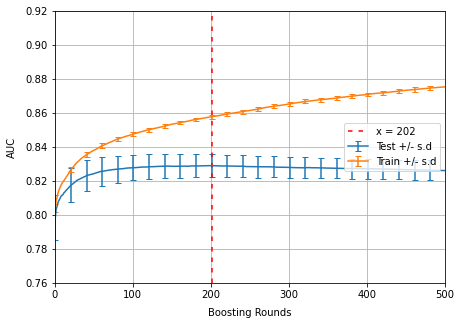

optimal training rounds: 202
optimal AUC: 0.8289768000000001


In [25]:
plt.figure(figsize=(7,5))
line_b = plt.errorbar((np.linspace(1,500,500)), np.mean(np.array(te_epoch_au), axis=0), 
             yerr=np.std(np.array(te_epoch_au), axis=0), errorevery=20, capsize=3, label='Test +/- s.d')

line_a = plt.errorbar((np.linspace(1,500,500)), np.mean(np.array(tr_epoch_au), axis=0), 
             yerr=np.std(np.array(tr_epoch_au), axis=0), errorevery=20, capsize=3, label='Train +/- s.d')
plt.xlabel('Boosting Rounds', labelpad=8) #, fontsize='large', fontweight='demibold')
plt.ylabel('AUC', labelpad=8) #, fontsize='large', fontweight='demibold')
plt.ylim(0.78,0.90)
plt.xlim(0,500)
plt.grid(True)
plt.axvline(x=np.argmax(np.mean(np.array(te_epoch_au), axis=0))+1, color='red', linestyle=(0,(3,4)),
            label=f'x = {np.argmax(np.mean(np.array(te_epoch_au), axis=0))+1}')
plt.legend(loc='center right')
# plt.savefig('boosting_rounds.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

print(f'optimal training rounds: {np.argmax(np.mean(np.array(te_epoch_au), axis=0))+1}')
print(f'optimal AUC: {np.max(np.mean(np.array(te_epoch_au), axis=0))}')

#### 20 runs for final evaluation metrics

In [11]:
threshold = 0.8 # inferred from 135 chart (and validated on hypertensive cohort in a previous version)

In [15]:
num_boost_round = 202

In [13]:
np.random.seed(seed=0)

seed_list = np.random.randint(0, 1000000, 20)
print(seed_list)

[985772 305711 435829 117952 963395 152315 882371 359783 304137 122579
 610581 448242 374564 735831 736326 310744 170584 839052 604474 541377]


In [29]:
# initialize evaluation score lists
tr_au, tr_as, tr_ps, tr_rs, te_fs = [], [], [], [], []
te_au, te_as, te_ps, te_rs, te_fs = [], [], [], [], []

for seed in seed_list:
    # split the data in to train and test for each random seed
    X_train, X_test, y_train, y_test = train_test_split(X_comb, y_comb, test_size=1/5, random_state=seed)

    # get data in required format for XGBoost - basic WEIGHTING for unbalanced data (defined at X/y top level)
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(dic.values()),
                         weight=[w_0 if y_train_i==0 else w_1 for y_train_i in y_train])
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(dic.values()),
                        weight=[w_0 if y_test_i==0 else w_1 for y_test_i in y_test])

    # using Learning API in XGBoost so that can store feature_names within the dMatrix
    model = xgb.train(params, dtrain, num_boost_round, verbose_eval=False)

    # calculate evaluation scores and append to score lists
    te_au.append(roc_auc_score(y_test, [pred for pred in model.predict(dtest, output_margin=True)]))
    te_as.append(accuracy_score(y_test, [pred>threshold for pred in model.predict(dtest)]))
    te_ps.append(precision_score(y_test, [pred>threshold for pred in model.predict(dtest)]))
    te_rs.append(recall_score(y_test, [pred>threshold for pred in model.predict(dtest)]))
    te_fs.append(f1_score(y_test, [pred>threshold for pred in model.predict(dtest)]))
    
    # print progress out
    print(te_au[-1], te_as[-1], te_ps[-1], te_rs[-1], te_fs[-1])

# calculate mean and standard deviation over the k-fold cross validation and append to results lists
results = [te_au, te_as, te_ps, te_rs, te_fs]

result_formatted = [f'{round(np.mean(np.array(te_au)),2)}+/-{round(np.std(np.array(te_au)),3)}',
                    f'{round(np.mean(np.array(te_as)),2)}+/-{round(np.std(np.array(te_as)),3)}',
                    f'{round(np.mean(np.array(te_ps)),2)}+/-{round(np.std(np.array(te_ps)),3)}',
                    f'{round(np.mean(np.array(te_rs)),2)}+/-{round(np.std(np.array(te_rs)),3)}',
                    f'{round(np.mean(np.array(te_fs)),2)}+/-{round(np.std(np.array(te_fs)),3)}']

# print final formatted result to screen
print(result_formatted)
            
# save results
pickle.dump(results, open('Results\\results_final_20_unbalanced.p', 'wb'))

0.827886432921555 0.922363325227416 0.40198863636363635 0.39088397790055246 0.3963585434173669
0.8315597513328328 0.9201116815275151 0.40796703296703296 0.3944223107569721 0.4010803511141121
0.8210511583064316 0.9155183283797171 0.3733850129198966 0.3894878706199461 0.3812664907651715
0.8305922920892496 0.9165090516076736 0.3852140077821012 0.396 0.3905325443786983
0.8310262964703229 0.9193010897955507 0.4140730717185386 0.39791937581274384 0.40583554376657827
0.8385950481317203 0.9245249031793209 0.4014285714285714 0.4014285714285714 0.4014285714285714
0.8272818534188824 0.9192110240475547 0.4034582132564842 0.3669724770642202 0.3843514070006864
0.8372111427666984 0.9190308925515627 0.38095238095238093 0.3731138545953361 0.376992376992377
0.8247103257887995 0.917409709087634 0.385752688172043 0.38420348058902276 0.3849765258215962
0.8379411078864859 0.9210123390074755 0.39917127071823205 0.3953488372093023 0.3972508591065292
0.8275501765243369 0.915158065387733 0.38346883468834686 0.3

#### Threshold selection

In [24]:
# splitting in to 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X_comb, y_comb, test_size=1/5, random_state=839052)

# using scikit learn API so that can use precision_recall curve
model = xgb.XGBClassifier(n_estimators=num_boost_round, max_depth=4, learning_rate=0.1, objective='binary:logistic', 
                          min_child_weight=64, use_label_encoder=False)
fitted_model = model.fit(X_train, y_train, sample_weight=[w_0 if y_train_i==0 else w_1 for y_train_i in y_train],
                         eval_metric='auc')

In [25]:
threshold=[]
f1_scores=[]
accuracy_scores=[]
precision_scores=[]
recall_scores=[]
roc_auc_scores=[]
for i in range(-100,100):
    threshold.append(0.5+i*0.005)
    f1_scores.append(f1_score(y_test, 
                              [pred>0.5+i*0.005 for pred in fitted_model.predict_proba(X_test)[:,1]]))
    accuracy_scores.append(accuracy_score(y_test, 
                                          [pred>0.5+i*0.005 for pred in fitted_model.predict_proba(X_test)[:,1]]))
    recall_scores.append(recall_score(y_test, 
                                      [pred>0.5+i*0.005 for pred in fitted_model.predict_proba(X_test)[:,1]],
                                      zero_division=0))
    precision_scores.append(precision_score(y_test, 
                                            [pred>0.5+i*0.005 for pred in fitted_model.predict_proba(X_test)[:,1]],
                                            zero_division=0))

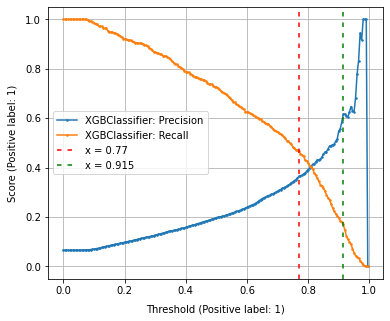

max f1 score: 0.4088995790739627
precision/recall at this point: 0.36441586280814575/0.4657534246575342

max accuracy score: 0.9384850941187066


In [27]:
plt.figure(figsize=(6,5))
plt.plot(threshold, precision_scores,
         label=f'XGBClassifier: Precision',# (F1 = {round(np.max(f1_scores),2)})',
         marker='.', markersize=3)
plt.plot(threshold, recall_scores,
         label=f'XGBClassifier: Recall',# (F1 = {round(np.max(f1_scores),2)})',
         marker='.', markersize=3)
plt.ylabel('Score (Positive label: 1)', labelpad=8) # fontsize='large', fontweight='demibold'
plt.xlabel('Threshold (Positive label: 1)', labelpad=8) # fontsize='large', fontweight='demibold'
plt.axvline(x=threshold[np.argmax(f1_scores)], color='red', linestyle=(0,(3,4)), 
                        label=f'x = {round(threshold[np.argmax(f1_scores)], 3)}')
plt.axvline(x=threshold[np.argmax(accuracy_scores)], color='green', linestyle=(0,(3,4)), 
                        label=f'x = {round(threshold[np.argmax(accuracy_scores)], 3)}')
plt.legend(loc='center left')
plt.grid(True)
plt.savefig('precision_recall_threshold_ht_2.jpg', format='jpg', dpi=300)
plt.show()

print(f'max f1 score: {np.max(f1_scores)}')
print(f'precision/recall at this point: {precision_scores[np.argmax(f1_scores)]}/{recall_scores[np.argmax(f1_scores)]}')
print()
print(f'max accuracy score: {np.max(accuracy_scores)}')

#### Measure the effect of additional data

In [27]:
# reasonable params (taken from a previous version of gridsearch)
params = {'max_depth':5, 'eta':0.2, 'objective':'binary:logistic', 'eval_metric':'auc', 'min_child_weight':64}
num_boost_round = 200

In [28]:
data_cuts = np.linspace(0.05, 1, 20)

results = []
results_formatted = []

for data_cut in data_cuts:
    
    X_cut = X_comb[:int(data_cut * n)]
    y_cut = y_comb[:int(data_cut * n)]

    k_fold_index_set = list(kf.split(X_cut))
    
    # get weights for the unbalanced data
    w_0 = len(y_cut) / (2 * sum(y_cut==0))
    w_1 = len(y_cut) / (2 * sum(y_cut==1))

    # initialize training and test accuracy score lists
    tr_au = []
    te_au = []
    
    evals_result = {}
    
    for fold in range(k_folds):
        # split the data in to the k-th fold using SKLearn k-fold split
        train_idx, test_idx = k_fold_index_set[fold]
        X_train, y_train, X_test, y_test = X_cut[train_idx], y_cut[train_idx], X_cut[test_idx], y_cut[test_idx]

        # get data in required format for XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(dic.values()),
                             weight=[w_0 if y_train_i==0 else w_1 for y_train_i in y_train])
        dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(dic.values()),
                            weight=[w_0 if y_test_i==0 else w_1 for y_test_i in y_test])# hypertensives

        # train XGBoost
        bst = xgb.train(params, dtrain, num_boost_round, evals=[(dtrain,'dtrain'),
                                                                (dtest,'dtest')],
                        early_stopping_rounds=20, evals_result=evals_result, verbose_eval=False)

        # calculate required metrics for train and test then append to score lists
        tr_au.append(list(evals_result['dtrain'].values())[0][bst.best_iteration])
        te_au.append(list(evals_result['dtest'].values())[0][bst.best_iteration])

    # calculate mean and standard deviation over the k-fold cross validation and append to results lists
    result = [round(data_cut,2),
              round(np.mean(np.array(tr_au)),3),
              round(np.std(np.array(tr_au)),3),
              round(np.mean(np.array(te_au)),3),
              round(np.std(np.array(te_au)),3)]
    results.append(result)

    result_formatted = [round(data_cut,2),
                        f'{round(np.mean(np.array(tr_au)),2)}+/-{round(np.std(np.array(tr_au)),2)}',
                        f'{round(np.mean(np.array(te_au)),2)}+/-{round(np.std(np.array(te_au)),2)}']
    results_formatted.append(result_formatted)

    # print result to screen
    print(result_formatted)
    
# save results
pickle.dump(results, open('Results\\results_data_CV_hypertensives.p', 'wb'))
pickle.dump(results_formatted, open('Results\\results_data_CV_formatted_hypertensives.p', 'wb'))

[0.05, '0.85+/-0.02', '0.82+/-0.02']
[0.1, '0.87+/-0.01', '0.82+/-0.02']
[0.15, '0.87+/-0.01', '0.83+/-0.01']
[0.2, '0.86+/-0.0', '0.83+/-0.01']
[0.25, '0.87+/-0.01', '0.83+/-0.01']
[0.3, '0.86+/-0.01', '0.82+/-0.01']
[0.35, '0.87+/-0.01', '0.82+/-0.01']
[0.4, '0.86+/-0.01', '0.82+/-0.01']
[0.45, '0.86+/-0.01', '0.82+/-0.01']
[0.5, '0.86+/-0.01', '0.83+/-0.01']
[0.55, '0.86+/-0.0', '0.83+/-0.01']
[0.6, '0.86+/-0.0', '0.83+/-0.0']
[0.65, '0.86+/-0.0', '0.82+/-0.01']
[0.7, '0.86+/-0.01', '0.83+/-0.01']
[0.75, '0.86+/-0.0', '0.82+/-0.0']
[0.8, '0.86+/-0.0', '0.83+/-0.0']
[0.85, '0.86+/-0.01', '0.83+/-0.0']
[0.9, '0.86+/-0.01', '0.83+/-0.01']
[0.95, '0.86+/-0.0', '0.83+/-0.01']
[1.0, '0.86+/-0.01', '0.83+/-0.01']


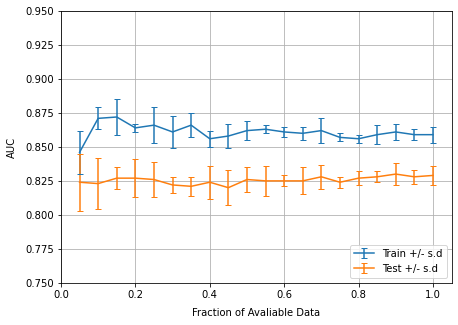

In [33]:
results = pickle.load(open('Results\\results_data_CV_hypertensives.p', 'rb'))

plt.figure(figsize=(7,5))
plt.errorbar(np.array(results)[:,0], np.array(results)[:,1], 
             yerr=np.array(results)[:,2], errorevery=1, capsize=3, label='Train +/- s.d')
plt.errorbar(np.array(results)[:,0], np.array(results)[:,3], 
             yerr=np.array(results)[:,4], errorevery=1, capsize=3, label='Test +/- s.d')
plt.legend(loc='lower right')
plt.ylim(0.75,0.95)
plt.xlim(0,1.05)
plt.ylabel('AUC', labelpad=8)
plt.xlabel('Fraction of Avaliable Data', labelpad=8)
plt.grid(True)
plt.savefig('effect_of_data.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# results of this show that we need to add more features or increase complextiy of model - NOT more data